#Vartiational Quantum Eigensolver based on Digital-Analog Quantum Computing (DAQC) approach

The following notebook implements VQE on DAQC for IQM Challenge at Womanium Hackathon

Team: RQC Hackathon Team
Creator: Artem Kuzmichev

In [ ]:
!pip install qiskit -q --no-warn-conflicts
!pip install pylatexenc -q --no-warn-conflicts
!pip install qutip -q --no-warn-conflicts

In [ ]:
import numpy as np
import qutip as qt

from typing import List 
from matplotlib import pyplot as plt
%matplotlib inline

from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import I, X, Z

#Qiskit Nature precalculations of Hamiltonian

In [ ]:
!pip install qiskit_nature[pyscf] -q --no-warn-conflicts
!pip install pyscf -q --no-warn-conflicts

In [ ]:
from qiskit_nature.settings import settings
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper

settings.dict_aux_operators = True

from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)

molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1
)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)

es_problem = ElectronicStructureProblem(driver)
second_q_op = es_problem.second_q_ops()
print(second_q_op["ElectronicEnergy"])

Fermionic Operator
register length=4, number terms=36
  -1.2563390730032498 * ( +_0 -_0 )
+ -0.47189600728114245 * ( +_1 -_1 )
+ -1.2563390730032498 * ( +_2 -_2 )
+ -0.47189600728114245 * ( +_3 -_3 )
+ -0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ -0. ...


In [ ]:
qubit_converter = QubitConverter(mapper=JordanWignerMapper())
qubit_op = qubit_converter.convert(second_q_op["ElectronicEnergy"])
print(qubit_op)

-0.8105479805373279 * IIII
+ 0.1721839326191554 * IIIZ
- 0.22575349222402372 * IIZI
+ 0.17218393261915543 * IZII
- 0.2257534922240237 * ZIII
+ 0.12091263261776627 * IIZZ
+ 0.16892753870087907 * IZIZ
+ 0.045232799946057826 * YYYY
+ 0.045232799946057826 * XXYY
+ 0.045232799946057826 * YYXX
+ 0.045232799946057826 * XXXX
+ 0.1661454325638241 * ZIIZ
+ 0.1661454325638241 * IZZI
+ 0.17464343068300453 * ZIZI
+ 0.12091263261776627 * ZZII


In [ ]:
qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
qubit_op = qubit_converter.convert(
    second_q_op["ElectronicEnergy"], num_particles=es_problem.num_particles
)
print(qubit_op)

-1.0523732457728594 * II
+ 0.3979374248431778 * IZ
- 0.39793742484317923 * ZI
- 0.011280104256233658 * ZZ
+ 0.18093119978423122 * XX


##Hamiltonian with XY-interaction

In [ ]:
def create_xy_hamiltonian(num_qubits: int, connectivity: List[List[int]],
                              h_coeffs: List[float]) -> np.ndarray:
    """Creates a global Hamiltonian consisting of a sum of one (g * X^i.Y^j) term per device connection.

    Args:
        num_qubits (int): number of qubits of the Hamiltonian
        connectivity (List[List[int]]): connectivity of the device
        h_coeffs (List[float]): list of coefficients of each XY term

    Returns:
        np.ndarray: tensored Hamiltonian
    """
    
    dim = 2 ** num_qubits
    num_connections = len(connectivity)
    xy_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)

    # create a matrix that is the sum of XY operators on all connected qubits,
    # tensored with the identity
    for c in range(num_connections):
        ops_to_tensor = [qt.identity(2)] * num_qubits
        ops_to_tensor[connectivity[c][0]] = qt.sigmax() 
        ops_to_tensor[connectivity[c][1]] = qt.sigmay() 
        xy_hamiltonian += h_coeffs[c] * np.array(qt.tensor(ops_to_tensor))

    return xy_hamiltonian

##Hamiltonian with sumXY-interaction

In [ ]:
def create_sum_hamiltonian(num_qubits: int, connectivity: List[List[int]],
                              h_coeffs: List[float]) -> np.ndarray:
    """Creates a global Hamiltonian consisting of a sum of one (g * (X^i+Y^i).(X^j+Y^j)) term per device connection.

    Args:
        num_qubits (int): number of qubits of the Hamiltonian
        connectivity (List[List[int]]): connectivity of the device
        h_coeffs (List[float]): list of coefficients of each term

    Returns:
        np.ndarray: tensored Hamiltonian
    """
    
    dim = 2 ** num_qubits
    num_connections = len(connectivity)
    sum_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)

    # create a matrix that is the sum of XY operators on all connected qubits,
    # tensored with the identity
    for c in range(num_connections):
        ops_to_tensor = [qt.identity(2)] * num_qubits
        ops_to_tensor[connectivity[c][0]] = qt.sigmax() + qt.sigmay() 
        ops_to_tensor[connectivity[c][1]] = qt.sigmax() + qt.sigmay() 
        sum_hamiltonian += h_coeffs[c] * np.array(qt.tensor(ops_to_tensor))

    return sum_hamiltonian

In [ ]:
num_qubits = 2
hamiltonian = create_xy_hamiltonian(num_qubits, [[0, 1]], [2]) 
analog_block = HamiltonianGate(data=hamiltonian, time=3) 

In [ ]:
ham_matrix = HamiltonianGate(data=hamiltonian, time=2).params[0]
print(np.array_str(ham_matrix.real.astype('int'), precision=1, suppress_small=True))

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


##Building the circuit

In [ ]:
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

print(f'Number of qubits: {H2_op.num_qubits}')

Number of qubits: 2


In [ ]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -1.85728


In [ ]:
seed = 170
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [ ]:
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ParameterVector

NUMBER OF LAYERS

In [ ]:
n_layers = 2 #we performed different number of layers, 2 gives the best result (close to the reference and quite stable)

Time parameter!

In [ ]:
theta_list = ParameterVector('θ', length=n_layers)
phi_list = ParameterVector('phi', length=n_layers)

times_list = ParameterVector('time', length=n_layers)

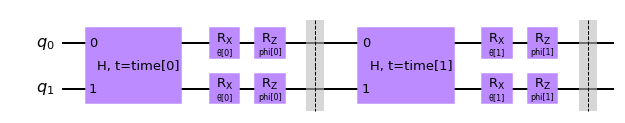

In [ ]:
no_qubits = H2_op.num_qubits


# Create a quantum circuit that is used for the ansatz
ansatz = QuantumCircuit(H2_op.num_qubits)

for layer in range(n_layers):
    analog_block = HamiltonianGate(data=hamiltonian, time=times_list[layer], label=f'H, t={times_list[layer]}') 
    ansatz.append(analog_block, list(range(no_qubits)))

    # add some single-qubit gates
    for i in range(no_qubits):
        ansatz.rx(theta_list[layer], i)
        ansatz.rz(phi_list[layer], i)

    ansatz.barrier()

ansatz.draw('mpl')

In [ ]:
counts = []
values = []

spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (no noise): -1.85162
Delta from reference energy value is 0.00566


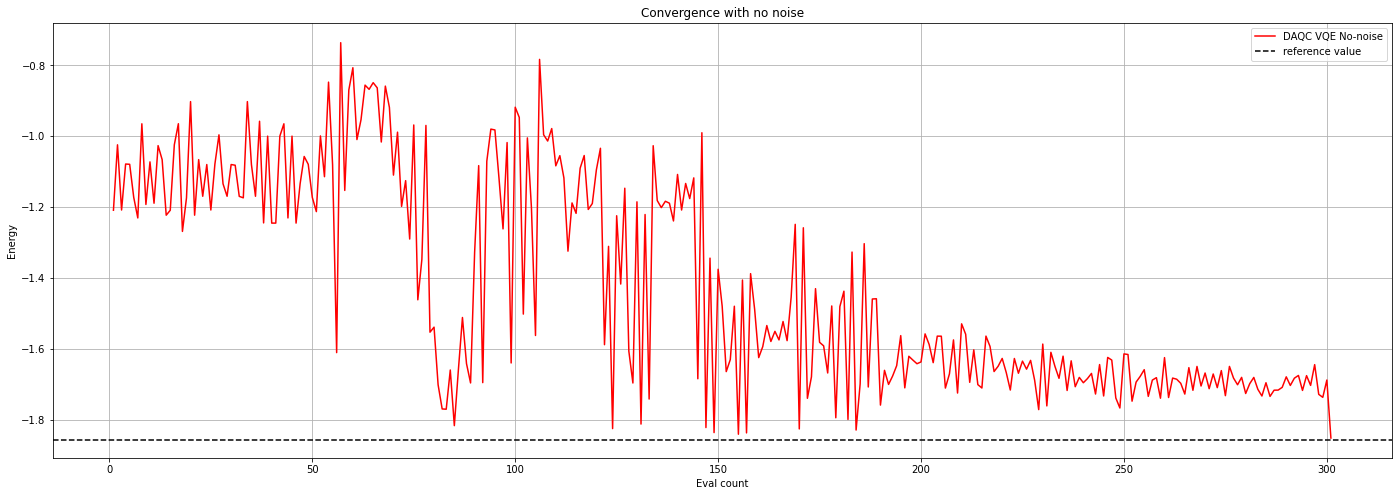

In [ ]:
plt.figure(figsize=(24, 8))
plt.plot(counts, values, color='r', label='DAQC VQE No-noise')
plt.axhline(y=ref_value, color='k', linestyle='--', label='reference value')
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Convergence with no noise')
plt.grid()
plt.legend()
plt.show()

number of layers: 1

VQE on Aer qasm simulator (no noise): -1.24458

Delta from reference energy value is 0.61269

number of layers: 2

VQE on Aer qasm simulator (no noise): -1.78531

Delta from reference energy value is 0.07196

number of layers: 3

VQE on Aer qasm simulator (no noise): -1.73524

Delta from reference energy value is 0.12204

number of layers: 7

VQE on Aer qasm simulator (no noise): -1.79912

Delta from reference energy value is 0.05816

7 layers:

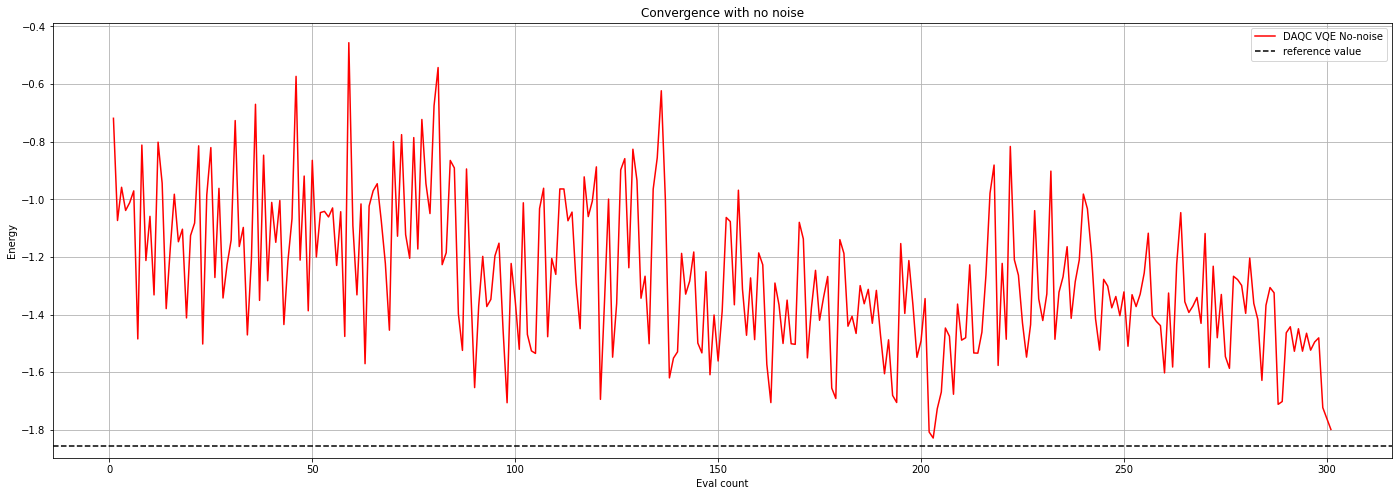

#sumXY-interaction

In [ ]:
num_qubits = 2
hamiltonian = create_sum_hamiltonian(num_qubits, [[0, 1]], [2]) 
analog_block = HamiltonianGate(data=hamiltonian, time=3) 

In [ ]:
ham_matrix = HamiltonianGate(data=hamiltonian, time=2).params[0]
print(np.array_str(ham_matrix.real.astype('int'), precision=1, suppress_small=True))

[[0 0 0 0]
 [0 0 4 0]
 [0 4 0 0]
 [0 0 0 0]]


##Building the circuit

In [ ]:
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

print(f'Number of qubits: {H2_op.num_qubits}')

Number of qubits: 2


In [ ]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -1.85728


In [ ]:
seed = 170
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [ ]:
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ParameterVector

NUMBER OF LAYERS

In [ ]:
n_layers = 2

Time parameter!

In [ ]:
theta_list = ParameterVector('θ', length=n_layers)
phi_list = ParameterVector('phi', length=n_layers)

times_list = ParameterVector('time', length=n_layers)

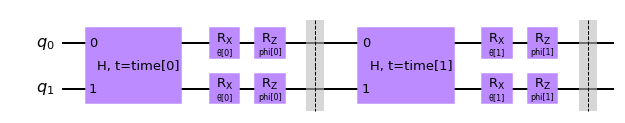

In [ ]:
no_qubits = H2_op.num_qubits


# Create a quantum circuit that is used for the ansatz
ansatz = QuantumCircuit(H2_op.num_qubits)

for layer in range(n_layers):
    analog_block = HamiltonianGate(data=hamiltonian, time=times_list[layer], label=f'H, t={times_list[layer]}') 
    ansatz.append(analog_block, list(range(no_qubits)))

    # add some single-qubit gates
    for i in range(no_qubits):
        ansatz.rx(theta_list[layer], i)
        ansatz.rz(phi_list[layer], i)

    ansatz.barrier()

ansatz.draw('mpl')

In [ ]:
counts = []
values = []

spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (no noise): -1.22541
Delta from reference energy value is 0.63187


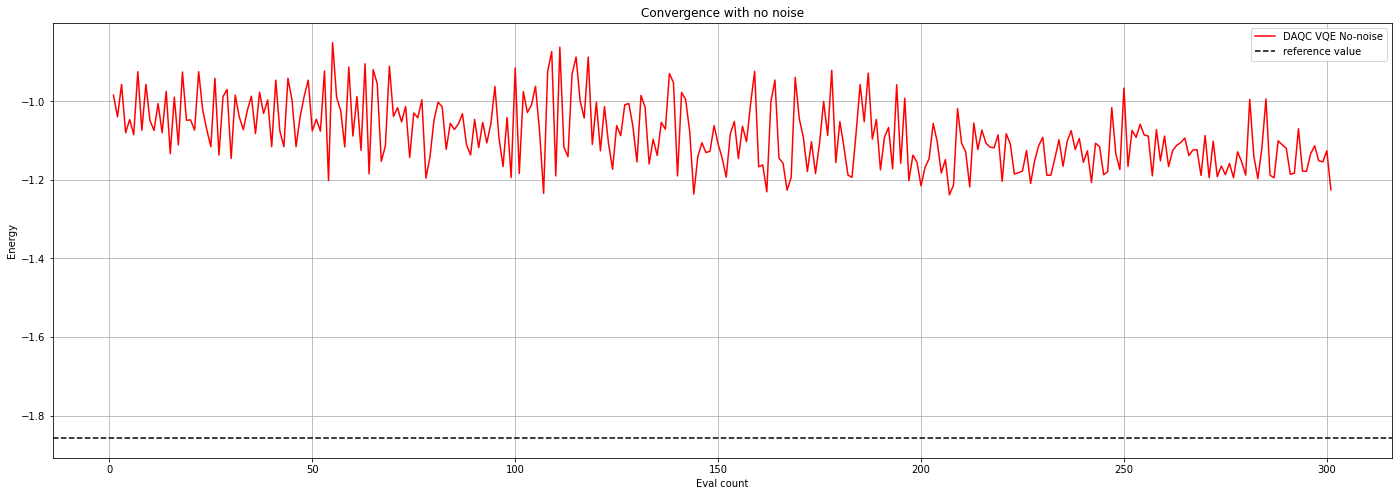

In [ ]:
plt.figure(figsize=(24, 8))
plt.plot(counts, values, color='r', label='DAQC VQE No-noise')
plt.axhline(y=ref_value, color='k', linestyle='--', label='reference value')
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Convergence with no noise')
plt.grid()
plt.legend()
plt.show()

number of layers: 1

VQE on Aer qasm simulator (no noise): -1.24458

Delta from reference energy value is 0.61269

number of kayers: 2

VQE on Aer qasm simulator (no noise): -1.22541

Delta from reference energy value is 0.63187
